# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
age = pd.read_csv('labels.csv')

In [3]:
print(age.head(10))

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39


In [4]:
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
print(age['file_name'].duplicated().sum())

0


In [6]:
print(age['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


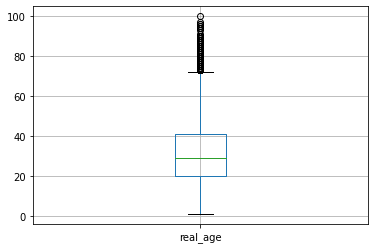

In [7]:
age.boxplot(column='real_age')
plt.show()

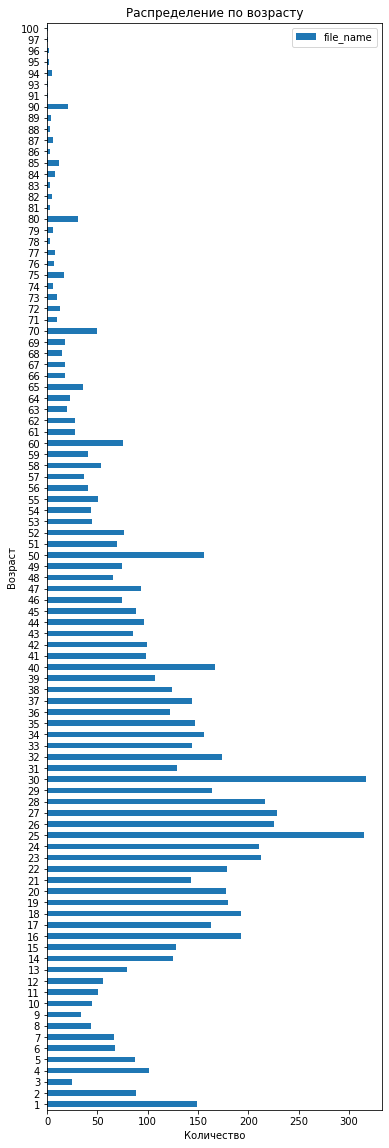

In [8]:
age.pivot_table(index='real_age', values='file_name', aggfunc='count').plot(
    title='Распределение по возрасту', kind='barh', figsize=(6,20))
plt.xlabel('Количество')
plt.ylabel('Возраст')
plt.show()

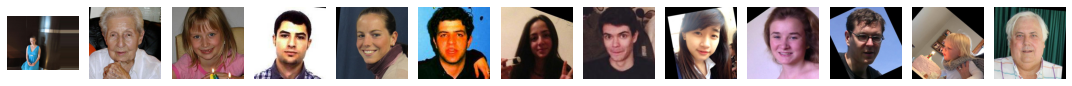

In [9]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

image_folder = '/datasets/faces/final_files'
image_files = os.listdir(image_folder)

num_images = random.randint(10, 15)
selected_images = random.sample(image_files, num_images)
 
fig, axes = plt.subplots(1, num_images, figsize=(15, 15)) 

for ax, image_name in zip(axes, selected_images):
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')  

plt.tight_layout()
plt.show()

Вывод: размер выборки достаточно большой для обучения модели. Фото разнообразные, разного качество, что тоже должно сказаться положительно. Можно заметить, что в круглые возраста (30, 40, 50 и тд лет) видны пики на гистограмме. Что даёт повод думать, что, возможно, часть возрастов округлена.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке. Вывод модели также в текстовой ячейке)

```python
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

def load_train(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2
    )
    train_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training'
    )
    return train_gen

def load_test(path):
    labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_gen = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation'
    )
    return test_gen

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15, steps_per_epoch=None, validation_steps=None):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    
    model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=test_data,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[early_stopping, checkpoint]
    )
    return model
```

```
2024-07-12 13:26:16.533287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-07-12 13:26:16.535798: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-07-12 13:26:17.586295: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-12 13:26:17.593269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-12 13:26:17.593319: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-12 13:26:17.593356: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-12 13:26:17.595542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-07-12 13:26:17.595953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-07-12 13:26:17.598349: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-07-12 13:26:17.599770: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-07-12 13:26:17.599827: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-12 13:26:17.602786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2024-07-12 13:26:17.804455: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2024-07-12 13:26:17.811748: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2024-07-12 13:26:17.812394: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x52e5180 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-07-12 13:26:17.812420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-07-12 13:26:17.966360: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4945fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-12 13:26:17.966400: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2024-07-12 13:26:17.968131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-07-12 13:26:17.968186: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-12 13:26:17.968200: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-12 13:26:17.968230: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-07-12 13:26:17.968266: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-07-12 13:26:17.968282: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-07-12 13:26:17.968297: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-07-12 13:26:17.968308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-12 13:26:17.971317: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-07-12 13:26:17.971383: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-07-12 13:26:18.341513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-07-12 13:26:18.341574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-07-12 13:26:18.341584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-07-12 13:26:18.344688: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-12 13:26:18.344749: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 12:52
  221184/94765736 [..............................] - ETA: 50s  
 1146880/94765736 [..............................] - ETA: 13s
 5947392/94765736 [>.............................] - ETA: 3s 
13279232/94765736 [===>..........................] - ETA: 1s
19644416/94765736 [=====>........................] - ETA: 1s
26140672/94765736 [=======>......................] - ETA: 0s
33062912/94765736 [=========>....................] - ETA: 0s
39469056/94765736 [===========>..................] - ETA: 0s
45211648/94765736 [=============>................] - ETA: 0s
51453952/94765736 [===============>..............] - ETA: 0s
57761792/94765736 [=================>............] - ETA: 0s
64258048/94765736 [===================>..........] - ETA: 0s
70639616/94765736 [=====================>........] - ETA: 0s
77037568/94765736 [=======================>......] - ETA: 0s
83320832/94765736 [=========================>....] - ETA: 0s
90570752/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 190 steps, validate for 48 steps
Epoch 1/15
2024-07-12 13:26:33.636011: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-12 13:26:34.273587: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 125s - loss: 214.8849 - mae: 10.8919 - val_loss: 371.1310 - val_mae: 14.3486
Epoch 2/15
190/190 - 111s - loss: 107.4841 - mae: 7.8650 - val_loss: 413.2599 - val_mae: 15.1673
Epoch 3/15
190/190 - 106s - loss: 93.1975 - mae: 7.3033 - val_loss: 258.8960 - val_mae: 11.9290
Epoch 4/15
190/190 - 106s - loss: 76.9928 - mae: 6.7074 - val_loss: 119.7695 - val_mae: 8.4315
Epoch 5/15
190/190 - 112s - loss: 69.9348 - mae: 6.4007 - val_loss: 134.3531 - val_mae: 8.7692
Epoch 6/15
190/190 - 115s - loss: 62.5633 - mae: 6.0263 - val_loss: 100.9981 - val_mae: 7.3607
Epoch 7/15
190/190 - 115s - loss: 56.7557 - mae: 5.7765 - val_loss: 88.7178 - val_mae: 6.9166
Epoch 8/15
190/190 - 117s - loss: 54.0991 - mae: 5.6071 - val_loss: 88.2232 - val_mae: 6.9035
Epoch 9/15
190/190 - 115s - loss: 47.1736 - mae: 5.2705 - val_loss: 83.6572 - val_mae: 6.6425
Epoch 10/15
190/190 - 115s - loss: 48.1185 - mae: 5.2948 - val_loss: 74.3794 - val_mae: 6.5749
Epoch 11/15
190/190 - 110s - loss: 40.9189 - mae: 4.9695 - val_loss: 76.4601 - val_mae: 6.5985
Epoch 12/15
190/190 - 111s - loss: 39.1442 - mae: 4.7597 - val_loss: 72.8656 - val_mae: 6.4707
Epoch 13/15
190/190 - 110s - loss: 36.7955 - mae: 4.6569 - val_loss: 68.6008 - val_mae: 6.1794
Epoch 14/15
190/190 - 109s - loss: 35.3892 - mae: 4.5163 - val_loss: 73.3236 - val_mae: 6.2296
Epoch 15/15
190/190 - 107s - loss: 31.4689 - mae: 4.2906 - val_loss: 90.9654 - val_mae: 7.2977
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 90.9654 - mae: 7.2977
Test MAE: 7.2977
```

## Анализ обученной модели

    В ходе проекта были получены данные с фото лиц с указанием их реального возраста. Нужно было научить модель предсказывать возраст по фото. Данные были проанализированы, дополнительной обработки не понадобилось. Затем подобран оптимальный вид модели с наименьшим результатом MAE. Лучшей оказалась модель с использованием структуры ResNet50 и аугментацией. А также с использованием алгоритма ADAM со значением learning_rate=0.0001 (выполнено условие: MAE меньше 8).